In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [ ]:
# 메모리 변수 모두 제거
all = [var for var in globals() if var[0] != "_"]
for var in all:
    del globals()[var]

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import nltk
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import os

In [ ]:
os.chdir(path)

In [ ]:
df = pd.read_csv('hankyung_news_stock.csv')
df

,index,Close,Open,High,Low,Volume,Change,title,en_list
0,2018-10-22,2161.71,2143.08,2163.21,2136.92,308740000.0,0.0025,방산 방심은 금물 방산 방심은 금물정유 화학업종 IMO 2020 카슈끄지 그리...,Blood-defense vigilant is a gold refinery indu...
1,2018-10-23,2106.10,2147.30,2148.80,2094.69,373470000.0,-0.0257,자동차 Daily Auto Check 자동차 Daily Auto Check유통 D...,Automotive Daily Auto CHECK DAILY AUTO CHECK D...
2,2018-10-24,2097.58,2119.19,2121.36,2092.10,399730000.0,-0.0040,유통 Daily 코멘트 및 뉴스 업데이트 Daily 코멘트 및 뉴스 업데이트디스플...,Distribution Daily Comments and News Updates D...
3,2018-10-25,2063.30,2046.67,2066.06,2033.81,376010000.0,-0.0163,건설업종 투자의 시대 투자의 시대자동차 흑자전환에 성공한 Tesla 흑자전환에 ...,Tesla Semiconductor IT Softer Market Ahead Sem...
4,2018-10-26,2027.15,2066.57,2066.57,2008.86,449200000.0,-0.0175,유통 Amazon 3Q18 Review 희비 공존 Amazon 3Q18 Revi...,Distribution Amazon 3q18 Review Right Coexist ...
...,...,...,...,...,...,...,...,...,...
732,2021-10-15,3015.06,3012.62,3021.90,2999.33,857800000.0,0.0088,오락 디즈니플러스 쇼케이스 요약 쇼케이스 내내 콘텐츠 강조화학 신사업 ...,Entertainment Disney Plus Showcase Summary Cor...
733,2021-10-18,3006.68,3017.48,3021.17,2990.44,926370000.0,-0.0028,제약 제약 바이오 Weekly 제약 바이오 주간 코멘트국내 주요 뉴스 및 공시...,Pharmaceutical Bio Weekly Major News & Public ...
734,2021-10-19,3029.04,3022.23,3034.53,3014.19,845700000.0,0.0074,방송 비디어 중국 규제 피해는 정말 없는 것 같습니다 중국 규제 피해는 정말 없는...,Broadcasting Videos China Regulatory Damage se...
735,2021-10-20,3013.13,3043.13,3047.24,3012.97,668300.0,-0.0053,조선 meritz 조선 기계 Daily 국내외 주요 뉴스 및 코멘트자동차 ...,Joseon Meritz Joseon Machinery Daily Daily Maj...


In [ ]:
from tensorflow.keras.preprocessing.text import text_to_word_sequence
for i in range(len(df)):
    df.en_list[i] = ' '.join(text_to_word_sequence(df.en_list[i]))

In [ ]:
df.head()

,index,Close,Open,High,Low,Volume,Change,title,en_list
0,2018-10-22,2161.71,2143.08,2163.21,2136.92,308740000.0,0.0025,방산 방심은 금물 방산 방심은 금물정유 화학업종 IMO 2020 카슈끄지 그리...,blood defense vigilant is a gold refinery indu...
1,2018-10-23,2106.10,2147.30,2148.80,2094.69,373470000.0,-0.0257,자동차 Daily Auto Check 자동차 Daily Auto Check유통 D...,automotive daily auto check daily auto check d...
2,2018-10-24,2097.58,2119.19,2121.36,2092.10,399730000.0,-0.0040,유통 Daily 코멘트 및 뉴스 업데이트 Daily 코멘트 및 뉴스 업데이트디스플...,distribution daily comments and news updates d...
3,2018-10-25,2063.30,2046.67,2066.06,2033.81,376010000.0,-0.0163,건설업종 투자의 시대 투자의 시대자동차 흑자전환에 성공한 Tesla 흑자전환에 ...,tesla semiconductor it softer market ahead sem...
4,2018-10-26,2027.15,2066.57,2066.57,2008.86,449200000.0,-0.0175,유통 Amazon 3Q18 Review 희비 공존 Amazon 3Q18 Revi...,distribution amazon 3q18 review right coexist ...


## 불용어 제거

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from nltk.corpus import stopwords
len(stopwords.words('english'))

179

In [ ]:
from nltk.tokenize import word_tokenize  
stop_words = set(stopwords.words('english')) 

title_str = []
for i in range(len(df)):
    word_tokens = word_tokenize(df.en_list[i].lower())
    result = ' '.join([w for w in word_tokens if w not in stop_words])
    title_str.append(result)

In [ ]:
df['title_cln'] = title_str
df.head()

,index,Close,Open,High,Low,Volume,Change,title,en_list,title_cln
0,2018-10-22,2161.71,2143.08,2163.21,2136.92,308740000.0,0.0025,방산 방심은 금물 방산 방심은 금물정유 화학업종 IMO 2020 카슈끄지 그리...,blood defense vigilant is a gold refinery indu...,blood defense vigilant gold refinery industry ...
1,2018-10-23,2106.10,2147.30,2148.80,2094.69,373470000.0,-0.0257,자동차 Daily Auto Check 자동차 Daily Auto Check유통 D...,automotive daily auto check daily auto check d...,automotive daily auto check daily auto check d...
2,2018-10-24,2097.58,2119.19,2121.36,2092.10,399730000.0,-0.0040,유통 Daily 코멘트 및 뉴스 업데이트 Daily 코멘트 및 뉴스 업데이트디스플...,distribution daily comments and news updates d...,distribution daily comments news updates daily...
3,2018-10-25,2063.30,2046.67,2066.06,2033.81,376010000.0,-0.0163,건설업종 투자의 시대 투자의 시대자동차 흑자전환에 성공한 Tesla 흑자전환에 ...,tesla semiconductor it softer market ahead sem...,tesla semiconductor softer market ahead semico...
4,2018-10-26,2027.15,2066.57,2066.57,2008.86,449200000.0,-0.0175,유통 Amazon 3Q18 Review 희비 공존 Amazon 3Q18 Revi...,distribution amazon 3q18 review right coexist ...,distribution amazon 3q18 review right coexist ...


In [ ]:
fre_word = [t for tr in df for t in df.title_cln] 

In [ ]:
s_fre_word = str(fre_word)

In [ ]:
s_fre_list = s_fre_word.split()

In [ ]:
len(s_fre_list)

2284630

In [ ]:
np.unique(s_fre_list)

array(['"2019', '"5', '"5g', ..., '키', '특히', '합'], dtype='<U108')

In [ ]:
len(np.unique(s_fre_list))

13067

In [ ]:
txt = nltk.Text(s_fre_list, name='word') # 빈도수 계산
print(txt)

<Text: word>


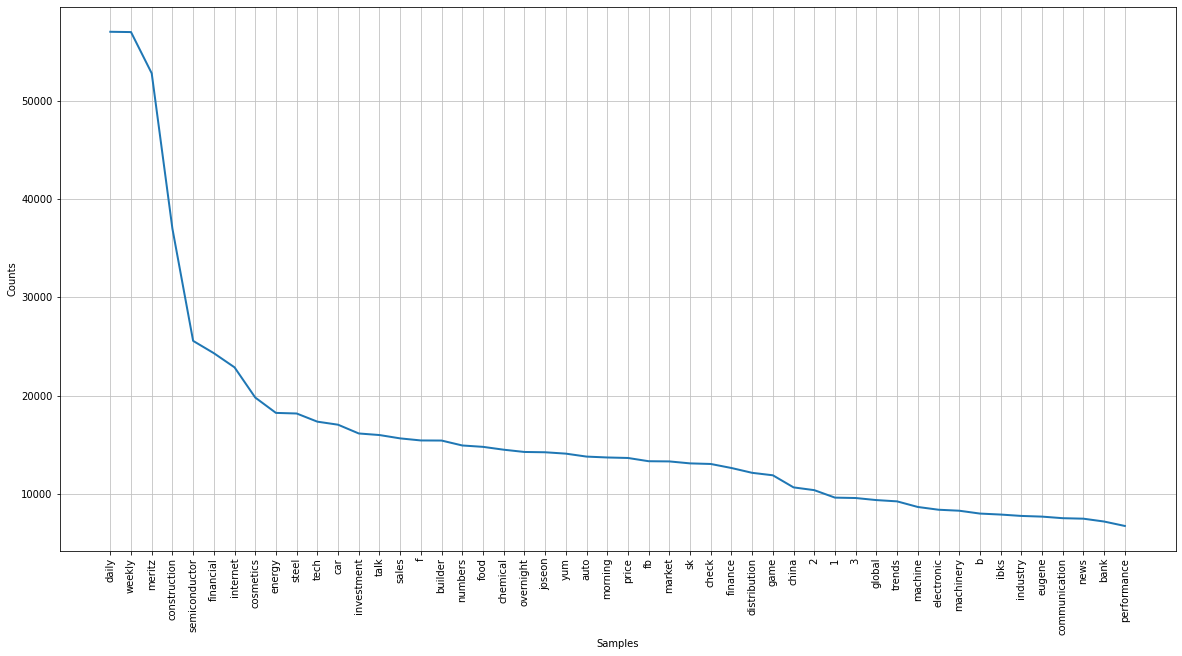

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(20,10))
txt.plot(50)

In [ ]:
sel_token=[f[0] for f in txt.vocab().most_common(500)]
print(sel_token[:10])

['daily', 'weekly', 'meritz', 'construction', 'semiconductor', 'financial', 'internet', 'cosmetics', 'energy', 'steel']


In [ ]:
def frev(doc):
    return [doc.count(stoken) for stoken in sel_token]

## 데이터 분리

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.title_cln, df.Change, test_size=0.1, random_state=0)

In [ ]:
train_x = [frev(d) for d in X_train] 
train_y = [d for d in y_train]

test_x = [frev(d) for d in X_test]
test_y = [d for d in y_test]

In [ ]:
train_x=np.asarray(train_x).astype('float32')
train_y=np.asarray(train_y).astype('float32')
test_x=np.asarray(test_x).astype('float32')
test_y=np.asarray(test_y).astype('float32')

In [ ]:
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((663, 500), (663,), (74, 500), (74,))

## 모델 학습

In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
np.random.seed(0)
model=models.Sequential()

model.add(layers.Dense(256, activation='relu',input_shape=(500,)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(1))

loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

earlystopping = EarlyStopping(monitor='val_loss', patience=10)
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

hist = model.fit(train_x,train_y,epochs=300,batch_size=200, validation_data=(test_x, test_y), verbose = 2, callbacks=[checkpoint, earlystopping])

Epoch 1/300
4/4 - 1s - loss: 3.1557 - mse: 22.4074 - val_loss: 0.0637 - val_mse: 0.1273

Epoch 00001: val_loss improved from inf to 0.06366, saving model to tmp/ckeckpointer.ckpt
Epoch 2/300
4/4 - 0s - loss: 0.2513 - mse: 0.5570 - val_loss: 0.2831 - val_mse: 0.5974

Epoch 00002: val_loss did not improve from 0.06366
Epoch 3/300
4/4 - 0s - loss: 0.1702 - mse: 0.3514 - val_loss: 0.1334 - val_mse: 0.2725

Epoch 00003: val_loss did not improve from 0.06366
Epoch 4/300
4/4 - 0s - loss: 0.0553 - mse: 0.1116 - val_loss: 0.0098 - val_mse: 0.0197

Epoch 00004: val_loss improved from 0.06366 to 0.00985, saving model to tmp/ckeckpointer.ckpt
Epoch 5/300
4/4 - 0s - loss: 0.0145 - mse: 0.0290 - val_loss: 0.0125 - val_mse: 0.0249

Epoch 00005: val_loss did not improve from 0.00985
Epoch 6/300
4/4 - 0s - loss: 0.0128 - mse: 0.0256 - val_loss: 0.0093 - val_mse: 0.0186

Epoch 00006: val_loss improved from 0.00985 to 0.00931, saving model to tmp/ckeckpointer.ckpt
Epoch 7/300
4/4 - 0s - loss: 0.0122 - ms

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               128256    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 9

In [ ]:
pred = model.predict(test_x)

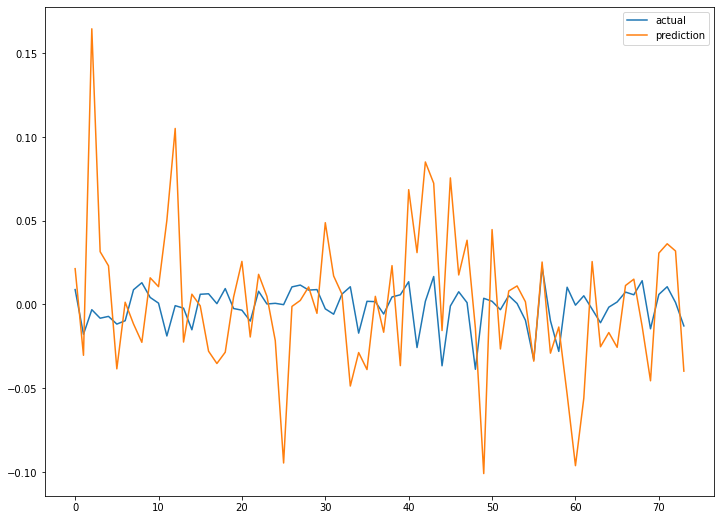

In [ ]:
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test), label='actual')
plt.plot(pred, label='prediction')
plt.legend() 
plt.show() 

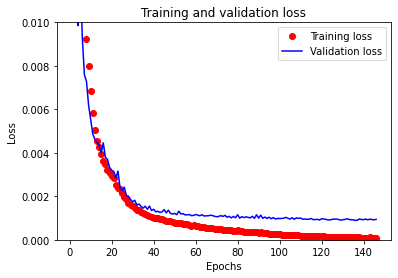

In [ ]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'ro', label='Training loss')

plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim((0,0.01))
plt.legend() 

plt.show()

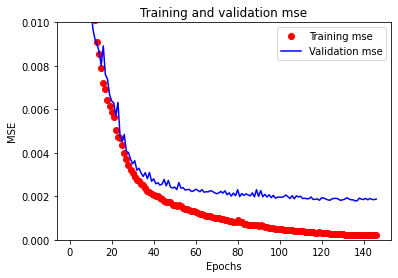

In [ ]:
mse = hist.history['mse']
val_mse = hist.history['val_mse']

epochs = range(1, len(mse) + 1)

plt.plot(epochs, mse, 'ro', label='Training mse')

plt.plot(epochs, val_mse, 'b', label='Validation mse')
plt.title('Training and validation mse')
plt.xlabel('Epochs')
plt.ylabel('MSE') 
plt.ylim((0,0.01))
plt.legend()

plt.show() 